In [1]:
import subprocess
import numpy as np
np.random.seed(2021) # For reproducibility
import glob
import corner
import subprocess
import numpy as np
import sympy as sm
import scipy.stats
import sympy as sm
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from string import ascii_uppercase

plt.rcParams['font.size'] = '16'
plt.rcParams["font.family"] = "Times New Roman"

def nrmse(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    rmse=np.sqrt(np.sum((actual - pred)**2)/len(actual))
    return rmse/np.mean(actual) * 100

def mean_ci(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def compute_mean_ci(data,figure_name='mean_std',save=False,show=False):
    full_data = data[0]
    full_hf = data[1]
    allfilenames = data[2]
    tv_time = full_data[0][0][:,0]
    hf_time = full_hf[0][0][:,0]
    all_tv_mean = []
    all_tv_std = []
    all_tv_assy = []
    all_hf_mean = []
    all_hf_std = []
    all_hf_assy = []
    for s in range(len(allfilenames)):
        tv_list = full_data[s] # Tumor volume
        hf_list = full_hf[s] # Hypoxic fraction
        # Tumor Volume
        mean = []
        min_d = []
        max_d = []
        std = []
        for t in tv_time:
            amean = 0
            amin = 100000
            amax = 0
            nrep = 0
            astd = 0
            tmp_data = []
            for i in range(len(tv_list)):
                b = np.where(tv_list[i].T[0] == t)
                if len(b[0]) > 0:
                    amean += tv_list[i].T[1][b]
                    tmp_data.append(tv_list[i].T[1][b])
                    nrep +=1
                    if amin > tv_list[i].T[1][b]:
                        amin = tv_list[i].T[1][b]
                    if amax < tv_list[i].T[1][b]:
                        amax = tv_list[i].T[1][b]
            amean = amean/nrep
            m = mean_ci(tmp_data,0.95)
            min_d.append(float(amin))
            max_d.append(float(amax))
            mean.append(float(m[0]))
            for i in range(len(tv_list)):
                b = np.where(tv_list[i].T[0] == t)
                if len(b[0]) > 0:
                    astd += (tv_list[i].T[1][b]-amean)**2
            astd = np.sqrt(astd/nrep)
            std.append(float(m[1]))
        std = np.array(std)
        mean = np.array(mean)
        min_d = np.array(min_d)
        max_d = np.array(max_d)
        asymmetric_error = [min_d, max_d]
        all_tv_mean.append(mean)
        all_tv_std.append(std)
        all_tv_assy.append(asymmetric_error)
        # Hypoxic Fraction
        mean = []
        std = []
        min_d = []
        max_d = []
        for t in hf_time:
            amean = 0
            amin = 100000
            amax = 0
            nrep = 0
            astd = 0
            tmp_data = []
            for i in range(len(hf_list)):
                b=np.where(hf_list[i].T[0] == t)
                if len(b[0]) > 0:
                    amean += hf_list[i].T[1][b]
                    tmp_data.append(hf_list[i].T[1][b])
                    nrep +=1
                    if amin > hf_list[i].T[1][b]:
                        amin = hf_list[i].T[1][b]
                    if amax < hf_list[i].T[1][b]:
                        amax = hf_list[i].T[1][b]
            amean = amean/nrep
            m = mean_ci(tmp_data,0.95)
            for i in range(len(hf_list)):
                b=np.where(hf_list[i].T[0] == t)
                if len(b[0]) > 0:
                    astd += (hf_list[i].T[1][b]-amean)**2
            astd = np.sqrt(astd/nrep)
            std.append(float(m[1]))
            min_d.append(float(amin))
            max_d.append(float(amax))
            mean.append(float(m[0]))
        std = np.array(std)
        mean = np.array(mean)
        min_d = np.array(min_d)
        max_d = np.array(max_d)
        asymmetric_error = [min_d, max_d]
        all_hf_mean.append(mean)
        all_hf_std.append(std)
        all_hf_assy.append(asymmetric_error)
    if show or save:
        for i in range(len(allfilenames)):
            fig, axes = plt.subplots(1,3, figsize=(20, 4), sharex=False)
            
            ax = axes[0]
            ax.text(0.5,0.9,allfilenames[i][1],horizontalalignment='center',transform=ax.transAxes)
            ax.errorbar(tv_time,all_tv_mean[i],all_tv_std[i],linestyle='None',color='black',marker='o',capsize=5,label=allfilenames[i][1])
            ax.set_xlabel('Time (days)')
            ax.set_ylabel('Tumor volume (cm³)');
            ax.set_xlim((0,30))
            ax.set_ylim((0,8))
            
            ax = axes[1]
            #ax.fill_between(hf_time, all_hf_mean[i]-all_hf_std[i], all_hf_mean[i]+all_hf_std[i], alpha=0.15, color='red')
            #ax.plot(hf_time, all_hf_mean[i]-all_hf_std[i], linewidth=1, linestyle="--",color='red')
            #ax.plot(hf_time, all_hf_mean[i]+all_hf_std[i], linewidth=1, linestyle="--",color='red')
            ax.errorbar(hf_time,all_hf_mean[i],all_hf_std[i],linestyle='None',color='black',marker='o',capsize=5)
            ax.set_xlabel('Time (days)')
            ax.set_ylabel('Hypoxic fraction')
            ax.set_xlim((11,18))
            ax.set_ylim((0,1))
            
            ax = axes[2]
            ax.errorbar(hf_time,1-all_hf_mean[i],all_hf_std[i].T[0],linestyle='None',color='black',marker='o',capsize=5)
            ax.set_xlabel('Time (days)')
            ax.set_ylabel('Well-vascularized fraction')
            ax.set_xlim((11,18))
            ax.set_ylim((0,1))
            if save:
                plt.savefig(figure_name + '_' + allfilenames[i][0] + '.pdf', bbox_inches = 'tight', pad_inches = 0.02)
            if show:
                plt.show()
            else:
                plt.close(fig) 
        fig, axes = plt.subplots(1,3, figsize=(20, 4), sharex=False, sharey=False)
        ax = axes[0]
        for i in range(len(all_tv_mean)):
            #ax.errorbar(tv_time,all_tv_mean[i],all_tv_std[i].T[0],linestyle='None',marker='o',capsize=5,label=allfilenames[i][1])
            ax.plot(tv_time, all_tv_mean[i],'-o',label=allfilenames[i][1])
        ax.legend(loc='upper left', fancybox=False, shadow=False, frameon=False)
        ax.set_xlabel('Time (days)')
        ax.set_ylabel('Tumor volume (cm³)');
        ax.set_xlim((0,30))
        ax.set_ylim((0,6))
        ax = axes[1]
        for i in range(len(all_hf_mean)):
            ax.plot(hf_time, all_hf_mean[i],'-o')
        ax.set_xlabel('Time (days)')
        ax.set_ylabel('Hypoxic fraction');
        ax.set_xlim((11,18))
        ax.set_ylim((0,1))
        ax = axes[2]
        for i in range(len(all_tv_mean)):
            ax.plot(hf_time, 1-all_hf_mean[i],'-o')
        ax.set_xlabel('Time (days)')
        ax.set_ylabel('Vascularized fraction');
        ax.set_xlim((11,18))
        ax.set_ylim((0,1))
        if save:
            plt.savefig(figure_name + '.pdf', bbox_inches = 'tight', pad_inches = 0.02)
        if show:
            plt.show()
        else:
            plt.close(fig) 
    return[[tv_time,all_tv_mean,all_tv_std,all_tv_assy],[hf_time,all_hf_mean,all_hf_std,all_hf_assy]]

def save_parameters(input_n,model_n,output):
    queso = output[0]
    ndim = len(queso[0])
    value2 = np.median(queso, axis=0)
    my_file = open('./outputQueso/parameters_d' + str(input_n) + '_m' + str(model_n) + '.dat','w')
    my_file.write(str(value2[0]))
    for i in range(1,len(value2)):
        my_file.write('\n')
        my_file.write(str(value2[i]))
    my_file.close()

def analysis_TVni():
    n, v, a, b, c, d, l = sm.symbols('n, v, a, b, c, d, l')
    N = a*n - b*n*v
    V = c*(1-v) - d*n*v
    NEqual = sm.Eq(N, 0)
    VEqual = sm.Eq(V, 0)
    equilibria=sm.solve( (NEqual,VEqual), n, v)
    for item in equilibria:
        print('Fixed point (%s, %s):'%(sm.simplify(item[0]), sm.expand(item[1])))
    eqMat = sm.Matrix([ N, V ])
    Mat = sm.Matrix([ n, v ])
    jacMat = eqMat.jacobian(Mat)
    I = sm.Matrix([ [l,0], [0,l] ])
    print('Jacobian %s' % jacMat)
    print('--------------------------------------------------------------------------------')
    for item in equilibria:
        eqmat = jacMat.subs([ (n, item[0]), (v, item[1]) ])
        print('The characteristic equation for the fixed point (%s, %s) are:'%(item[0], item[1]))
        #print(eqmat)
        #print(eqmat-I)
        A=eqmat-I
        #print(A.det())
        print(sm.collect(A.det(),l))
        print('The eigenvalues are %s:'%eqmat.eigenvals().keys())
        print('--------------------------------------------------------------------------------')

def fitting_solution(input_n,model_n,queso,data,allfilenames,show=False,save=False,extra=False,pos=0,using_chain=False):
    model_names=["T    ",
                 "TV1  ",
                 "TV2  ",
                 "TVni1",
                 "TVni2",
                 "TVi1 ",
                 "TVi2 ",
                 "TVe1 ",
                 "TVe2 ",
                 "TVie1",
                 "TVie2"]
    cal_par = np.loadtxt('./outputQueso/parameters_d123_m6.dat')
    queso_par = np.loadtxt('./outputQueso/lastchain_d123_m6.dat')
    cal_par45 = np.loadtxt('./outputQueso/parameters_d45_m10.dat')
    queso_par45 = np.loadtxt('./outputQueso/lastchain_d45_m10.dat')
    #inds = np.random.randint(len(queso), size=10)
    if pos < 8:
        inds = np.random.randint(len(queso), size=(1000,len(queso[0])))
    else:
        inds = np.random.randint(len(queso), size=(1000,len(queso)))
    inds_par = np.random.randint(len(queso_par), size=(1000,len(queso_par[0])))
    inds_par45 = np.random.randint(len(queso_par45), size=(1000,len(queso_par45[0])))
    last_p = 0
    if model_n >= 10:
        last_p = 8
    elif model_n >= 6:
        last_p = 6
    elif model_n >= 4:
        last_p = 4
    elif model_n >= 2:
        last_p = 3
    files = str(input_n)
    n_files = len(files)
    all_tv = []
    all_vf = []
    all_hf = []
    all_min_tv = []
    all_max_tv = []
    all_min_hf = []
    all_max_hf = []
    for f in range(n_files):
        dt_time = data[0][0]
        tv_time = np.arange(dt_time[0],dt_time[-1]+0.25,0.25)
        tv_mean = data[0][1][int(files[f])-1]
        tv_std = data[0][2][int(files[f])-1]
        hf_time = data[1][0]
        hf_mean = data[1][1][int(files[f])-1]
        hf_std = data[1][2][int(files[f])-1]
        if model_n > 1:
            sol_data = []
            sol_hypo = []
            if model_n == 2:
                for ind in inds:
                    sample = queso[ind]
                    y_sp = odeint(model_2, t=tv_time, y0=[tv_mean[0],1-sample[last_p+f]], args=tuple([[sample[0],sample[1],sample[2]]]))
                    sol_data.append(y_sp)
                    sol_hypo.append(1-y_sp[:,1])
            elif model_n == 3:
                for ind in inds:
                    sample = queso[ind]
                    y_sp = odeint(model_3, t=tv_time, y0=[tv_mean[0],1-sample[last_p+f]], args=tuple([[sample[0],sample[1],sample[2]]]))
                    sol_data.append(y_sp)
                    sol_hypo.append(1-y_sp[:,1])
            elif model_n == 4:
                for ind in inds:
                    sample = queso[ind]
                    y_sp = odeint(model_4, t=tv_time, y0=[tv_mean[0],1-sample[last_p+f]], args=tuple([[sample[0],sample[1],sample[2],sample[3]]]))
                    sol_data.append(y_sp)
                    sol_hypo.append(1-y_sp[:,1])
            elif model_n == 5:
                for ind in inds:
                    sample = queso[ind]
                    y_sp = odeint(model_5, t=tv_time, y0=[tv_mean[0],1-sample[last_p+f]], args=tuple([[sample[0],sample[1],sample[2],sample[3]]]))
                    sol_data.append(y_sp)
                    sol_hypo.append(1-y_sp[:,1])
            elif model_n == 6:
                for ind in inds:
                    sample = np.zeros(len(queso[0]))
                    for si in range(len(sample)):
                        sample[si] = queso[ind[si]][si].copy()
                    #sample = queso[ind].copy()
                    if int(files[f]) == 1:
                        sample[4] = 0
                    y_sp = odeint(model_6, t=tv_time, y0=[tv_mean[0],1-sample[last_p+f]], args=tuple([[sample[0],sample[1],sample[2],sample[3],sample[4],sample[5]]]))
                    sol_data.append(y_sp)
                    sol_hypo.append(1-y_sp[:,1])
            elif model_n == 7:
                for ind in inds:
                    sample = queso[ind].copy()
                    if int(files[f]) == 1:
                        sample[4] = 0.0
                    y_sp = odeint(model_7, t=tv_time, y0=[tv_mean[0],1-sample[last_p+f]], args=tuple([[sample[0],sample[1],sample[2],sample[3],sample[4],sample[5]]]))
                    sol_data.append(y_sp)
                    sol_hypo.append(1-y_sp[:,1])
            elif model_n == 8:
                for ind in inds:
                    sample = queso[ind].copy()
                    if int(files[f]) == 1:
                        sample[4] = 0.0
                    y_sp = odeint(model_8, t=tv_time, y0=[tv_mean[0],1-sample[last_p+f]], args=tuple([[sample[0],sample[1],sample[2],sample[3],sample[4],sample[5]]]))
                    sol_data.append(y_sp)
                    sol_hypo.append(1-y_sp[:,1])
            elif model_n == 9:
                for ind in inds:
                    sample = queso[ind].copy()
                    if int(files[f]) == 1:
                        sample[4] = 0.0
                    y_sp = odeint(model_9, t=tv_time, y0=[tv_mean[0],1-sample[last_p+f]], args=tuple([[sample[0],sample[1],sample[2],sample[3],sample[4],sample[5]]]))
                    sol_data.append(y_sp)
                    sol_hypo.append(1-y_sp[:,1])
            elif model_n == 10:
                #for ind in inds:
                for ii in range(len(inds)):
                    ind = inds[ii]
                    if pos < 8:
                        sample = np.zeros(len(queso[0]))
                    else:
                        sample = np.zeros(1)
                    for si in range(len(sample)):
                        if pos < 8:
                            sample[si] = queso[ind[si]][si].copy()
                        else:
                            sample[si] = queso[ind[si]].copy()
                    #sample = queso[ind].copy()
                    if int(files[f]) == 1:
                        sample[4] = 0.0
                        sample[6] = 0.0
                    if int(files[f]) == 4:
                        sample[0] = 0.0
                    if input_n == 6:
                        full_pars = [queso_par[inds_par[ii][0]][0],queso_par[inds_par[ii][1]][1],queso_par[inds_par[ii][2]][2],queso_par[inds_par[ii][3]][3],queso_par[inds_par[ii][4]][4],queso_par[inds_par[ii][5]][5],queso_par45[inds_par45[ii][0]][0],queso_par45[inds_par45[ii][1]][1]]
                        if extra:
                            full_pars[pos] = sample[1]
                        y_sp = odeint(model_10, t=tv_time, y0=[tv_mean[0],1-sample[0]], args=tuple([[full_pars[0],full_pars[1],full_pars[2],full_pars[3],full_pars[4],full_pars[5],full_pars[6],full_pars[7]]]))
                    elif input_n == 6:
                        y_sp = odeint(model_10, t=tv_time, y0=[tv_mean[0],1-sample[8]], args=tuple([[sample[0],sample[1],sample[2],sample[3],sample[4],sample[5],sample[6],sample[7]]]))
                    else:
                        y_sp = odeint(model_10, t=tv_time, y0=[tv_mean[0],1-sample[2+f]], args=tuple([[queso_par[inds_par[ii][0]][0],queso_par[inds_par[ii][1]][1],queso_par[inds_par[ii][2]][2],queso_par[inds_par[ii][3]][3],queso_par[inds_par[ii][4]][4],queso_par[inds_par[ii][5]][5],sample[0],sample[1]]]))
                    sol_data.append(y_sp)
                    sol_hypo.append(1-y_sp[:,1])
            elif model_n == 11:
                for ind in inds:
                    sample = queso[ind].copy()
                    if int(files[f]) == 1:
                        sample[4] = 0.0
                        sample[6] = 0.0
                    y_sp = odeint(model_11, t=tv_time, y0=[tv_mean[0],1-sample[last_p+f]], args=tuple([[sample[0],sample[1],sample[2],sample[3],sample[4],sample[5],sample[6],sample[7]]]))
                    sol_data.append(y_sp)
                    sol_hypo.append(1-y_sp[:,1])
            arr = np.empty([len(sol_data),len(sol_data[0])])
            for i in range(len(sol_data)):
                arr[i,:]=sol_data[i][:,0]
            avg_pre = []
            min_pre = []
            max_pre = []
            for i in range(len(arr[0])):
                m = mean_confidence_interval(arr[:,i],0.95)
                avg_pre.append(m[0])
                min_pre.append(m[1])
                max_pre.append(m[2])
            tv_avg_pre_vf = avg_pre 
            arr = np.empty([len(sol_data),len(sol_data[0])])
            for i in range(len(sol_data)):
                arr[i,:]=sol_data[i][:,1]
            avg_pre_h = []
            min_pre_h = []
            max_pre_h = []
            for i in range(len(arr[0])):
                m = mean_confidence_interval(arr[:,i],0.95)
                avg_pre_h.append(m[0])
                min_pre_h.append(m[1])
                max_pre_h.append(m[2])
            vf_avg_pre_vf = avg_pre_h
            hf_avg_pre_vf = [1.0 - x for x in vf_avg_pre_vf]
        all_tv.append(tv_avg_pre_vf)
        all_vf.append(vf_avg_pre_vf)
        all_hf.append(hf_avg_pre_vf)
        all_min_tv.append(min_pre)
        all_max_tv.append(max_pre)
        all_min_hf.append(min_pre_h)
        all_max_hf.append(max_pre_h)    
    if show or save:
        fig, axes = plt.subplots(n_files,2, figsize=(14, 4.5*n_files), sharex=False)
        for f in range(n_files):
            dt_time = data[0][0]
            tv_time = np.arange(dt_time[0],dt_time[-1]+0.25,0.25)
            tv_mean = data[0][1][int(files[f])-1]
            tv_std = data[0][2][int(files[f])-1]
            hf_time = data[1][0]
            hf_mean = data[1][1][int(files[f])-1]
            hf_std = data[1][2][int(files[f])-1]
            min_pre = all_min_tv[f]
            max_pre = all_max_tv[f]
            tv_avg_pre_vf = all_tv[f]
            min_pre_h = all_min_hf[f]
            max_pre_h = all_max_hf[f]
            hf_avg_pre_vf = all_hf[f]
            if n_files == 1:
                ax = axes[0]
            else:
                ax = axes[f][0]
            #ax.text(0.5,0.9,allfilenames[int(files[f])-1][1],horizontalalignment='center',transform=ax.transAxes)
            ax.errorbar(dt_time,tv_mean,tv_std,linestyle='None',color='black',marker='o',capsize=5,label='Experimental data')
            #ax.fill_between(tv_time, min_pre, max_pre, color='blue')
            
            ax.fill_between(tv_time, min_pre, max_pre, alpha=0.25, color='blue')
            ax.plot(tv_time, min_pre, linewidth=1, linestyle="--",color='blue')
            ax.plot(tv_time, max_pre, linewidth=1, linestyle="--",color='blue')
            avg_tv_full = []
            Tmin_tv_full = []
            Tmax_tv_full = []
            for t in range(len(dt_time)):
                b = np.where(tv_time == dt_time[t])
                if len(b[0]) > 0:
                    avg_tv_full.append(tv_avg_pre_vf[b[0][0]])
                    Tmin_tv_full.append(min_pre[b[0][0]])
                    Tmax_tv_full.append(max_pre[b[0][0]])
            r_ccc = ccc(tv_mean, np.array(avg_tv_full))
            r_ccc_min = ccc(tv_mean, np.array(Tmin_tv_full))
            r_ccc_max = ccc(tv_mean, np.array(Tmax_tv_full))
            m_ccc = np.array([r_ccc_min,r_ccc_max])
            print(r_ccc,m_ccc.mean(),m_ccc.std())
            r_pcc = pcc(tv_mean, np.array(avg_tv_full))
            r_mape = mape(tv_mean, np.array(avg_tv_full))
            r_nrmse = nrmse(tv_mean, np.array(avg_tv_full))
            if f == 0:
                ax.plot(0,0,'-', linewidth=5,color='blue',label='Model output')
                #ax.legend(loc='lower right', bbox_to_anchor=(1.75, -0.4),ncol=4,fancybox=False, shadow=False, frameon=False,fontsize=18)
                ax.legend(loc='upper center',bbox_to_anchor=(0.65, 1),ncol=1,fancybox=False, shadow=False, frameon=False)
            ax.text(.05,.9,ascii_uppercase[2*f]+')',horizontalalignment='center',transform=ax.transAxes,fontsize=18)
            ax.text(.05,.7,'CCC/PCC = {:.2f}/{:.2f}'.format(r_ccc,r_pcc),horizontalalignment='left',transform=ax.transAxes)
            ax.text(.05,.8,'MAPE = {:.2f}%'.format(r_mape),horizontalalignment='left',transform=ax.transAxes)
            #ax.text(.05,.6,'NRMSE = {:.2f}%'.format(r_nrmse),horizontalalignment='left',transform=ax.transAxes)
            ax.set_xlabel('Time (days)')
            ax.set_ylabel('Tumor volume (cm³)');
            ax.set_xlim((0,30))
            if n_files == 1:
                maxp = [0.6]
                ax.set_ylim((0,maxp[f]))
                ax = axes[1]
            else:
                ax.set_ylim((0,8))
                ax = axes[f][1]
            #ax.errorbar(hf_time,hf_mean,hf_std,linestyle='None',color='black',marker='o',capsize=5)
            #ax.fill_between(tv_time, [1.0 - x for x in max_pre_h], [1.0 - x for x in min_pre_h], color='blue')
            #ax.plot(tv_time, hf_avg_pre_vf, color='blue', label='Calibration with means (95% CI)')
            #avg_hf_full = []
            #for t in range(len(hf_time)):
            #    b = np.where(tv_time == hf_time[t])
            #    if len(b[0]) > 0:
            #        avg_hf_full.append(hf_avg_pre_vf[b[0][0]])
            #r_ccc = ccc(hf_mean, np.array(avg_hf_full))
            #r_pcc = pcc(hf_mean, np.array(avg_hf_full))
            #r_mape = mape(hf_mean, np.array(avg_hf_full))
            #ax.text(.5,.9,'CCC/PCC = {:.2f}/{:.2f}'.format(r_ccc,r_pcc),horizontalalignment='left',transform=ax.transAxes)
            #ax.text(.5,.8,'MAPE = {:.2f}%'.format(r_mape),horizontalalignment='left',transform=ax.transAxes)
            #ax.set_xlabel('Time (days)')
            #ax.set_ylabel('Hypoxic fraction')
            #ax.set_xlim((0,30))
            #ax.set_ylim((0,1))
            #if n_files == 1:
            #    ax = axes[2]
            #else:
            #    ax = axes[f][2]
            ax.errorbar(hf_time,1-hf_mean,hf_std,linestyle='None',color='black',marker='o',capsize=5)
            #ax.fill_between(tv_time, min_pre_h, max_pre_h, color='blue')
            
            ax.fill_between(tv_time, min_pre_h, max_pre_h, alpha=0.25, color='blue')
            ax.plot(tv_time, min_pre_h, linewidth=1, linestyle="--",color='blue')
            ax.plot(tv_time, max_pre_h, linewidth=1, linestyle="--",color='blue')
            
            #ax.plot(tv_time, [1.0 - x for x in hf_avg_pre_vf], color='blue', label='Calibration with means (95% CI)')
            
            avg_hf_full = []
            for t in range(len(hf_time)):
                b = np.where(tv_time == hf_time[t])
                if len(b[0]) > 0:
                    avg_hf_full.append(1.0-hf_avg_pre_vf[b[0][0]])
            r_ccc = ccc(1.0-hf_mean, np.array(avg_hf_full))
            r_mape = mape(1.0-hf_mean, np.array(avg_hf_full))
            r_nrmse = nrmse(1.0-hf_mean, np.array(avg_hf_full))
            ax.text(.05,.9,ascii_uppercase[2*f+1]+')',horizontalalignment='center',transform=ax.transAxes,fontsize=18)
            ax.text(.05,.7,'CCC = {:.2f}'.format(r_ccc),horizontalalignment='left',transform=ax.transAxes)
            ax.text(.05,.8,'MAPE = {:.2f}%'.format(r_mape),horizontalalignment='left',transform=ax.transAxes)
            #ax.text(.5,.7,'NRMSE = {:.2f}%'.format(r_nrmse),horizontalalignment='left',transform=ax.transAxes)
            ax.set_xlabel('Time (days)')
            ax.set_ylabel('Well-vascularized fraction')
            ax.set_xlim((0,30))
            ax.set_ylim((0,1))
        if save:
            if extra:
                plt.savefig('fig_mean_d' + str(input_n) + '_m' + str(model_n) + '_pos' + str(pos) + '.pdf', bbox_inches = 'tight', pad_inches = 0.02)
            else:
                plt.savefig('fig_mean_d' + str(input_n) + '_m' + str(model_n) + '.pdf', bbox_inches = 'tight', pad_inches = 0.02)
        if show == True:
            plt.show()
        else:
            plt.close(fig) 
    return [[all_tv,all_min_tv,all_max_tv],[all_hf,all_min_hf,all_max_hf]]
        
def model_1(y, t, theta):
    tumor = theta[0] * y[0]
    return tumor

def model_2(y, t, theta):
    tumor = theta[0] * y[0]
    vessel = theta[1] * ( 1.0 - y[1] ) - theta[2] * y[0] * y[1]
    return [tumor,vessel]
    
def model_3(y, t, theta):
    tumor = theta[0] * y[0] * y[1]
    vessel = theta[1] * ( 1.0 - y[1] ) - theta[2] * y[0] * y[1]
    return [tumor,vessel]
    
def model_4(y, t, theta):
    tumor = theta[0] * y[0] - theta[3] * y[0] * y[1]
    vessel = theta[1] * ( 1.0 - y[1] ) - theta[2] * y[0] * y[1]
    return [tumor,vessel]
    
def model_5(y, t, theta):
    tumor = theta[0] * y[0] * y[1] - theta[3] * y[0] * y[1]
    vessel = theta[1] * ( 1.0 - y[1] ) - theta[2] * y[0] * y[1]
    return [tumor,vessel]

def model_6(y, t, theta):
    D = 1.0
    if t>=7:
        n_treat = int((t-7)/3)
        for n in range(0,n_treat+1):
            D += theta[4]*np.exp(-theta[5]*(t-(7+n*3)))
    tumor = theta[0] * y[0] - D * theta[3] * y[0] * y[1]
    vessel = theta[1] * ( 1.0 - y[1] ) - theta[2] * y[0] * y[1]
    return [tumor,vessel]
    
def model_7(y, t, theta):
    D = 1.0
    if t>=7:
        n_treat = int((t-7)/3)
        for n in range(0,n_treat+1):
            D += theta[4]*np.exp(-theta[5]*(t-(7+n*3)))
    tumor = theta[0] * y[0] * y[1] - D * theta[3] * y[0] * y[1]
    vessel = theta[1] * ( 1.0 - y[1] ) - theta[2] * y[0] * y[1]
    return [tumor,vessel]

def model_8(y, t, theta):
    De = 1.0
    if t>=13:
        De += theta[4]*np.exp(-theta[5]*(t-13))
    if t>=14:
        De += theta[4]*np.exp(-theta[5]*(t-14))
    if t>=15:
        De += theta[4]*np.exp(-theta[5]*(t-15))
    if t>=16:
        De += theta[4]*np.exp(-theta[5]*(t-16))
    if t>=17:
        De += theta[4]*np.exp(-theta[5]*(t-17))
    tumor = theta[0] * y[0] - theta[3] * y[0] * y[1]
    vessel = De * theta[1] * ( 1.0 - y[1] ) - theta[2] * y[0] * y[1]
    return [tumor,vessel]
    
def model_9(y, t, theta):
    De = 1.0
    if t>=13:
        De += theta[4]*np.exp(-theta[5]*(t-13))
    if t>=14:
        De += theta[4]*np.exp(-theta[5]*(t-14))
    if t>=15:
        De += theta[4]*np.exp(-theta[5]*(t-15))
    if t>=16:
        De += theta[4]*np.exp(-theta[5]*(t-16))
    if t>=17:
        De += theta[4]*np.exp(-theta[5]*(t-17))
    tumor = theta[0] * y[0] * y[1] - theta[3] * y[0] * y[1]
    vessel = De * theta[1] * ( 1.0 - y[1] ) - theta[2] * y[0] * y[1]
    return [tumor,vessel]
    
def model_10(y, t, theta):
    D = 1.0
    De = 1.0
    if t>=7:
        n_treat = int((t-7)/3)
        for n in range(0,n_treat+1):
            D += theta[4]*np.exp(-theta[5]*(t-(7+n*3)))
    if t>=13:
        De += theta[6]*np.exp(-theta[7]*(t-13))
    if t>=14:
        De += theta[6]*np.exp(-theta[7]*(t-14))
    if t>=15:
        De += theta[6]*np.exp(-theta[7]*(t-15))
    if t>=16:
        De += theta[6]*np.exp(-theta[7]*(t-16))
    if t>=17:
        De += theta[6]*np.exp(-theta[7]*(t-17))
    tumor = theta[0] * y[0] - D * theta[3] * y[0] * y[1]
    vessel = De * theta[1] * ( 1.0 - y[1] ) - theta[2] * y[0] * y[1]
    return [tumor,vessel]
    
def model_11(y, t, theta):
    D = 1.0
    De = 1.0
    if t>=7:
        n_treat = int((t-7)/3)
        for n in range(0,n_treat+1):
            D += theta[4]*np.exp(-theta[5]*(t-(7+n*3)))
    if t>=13:
        De += theta[6]*np.exp(-theta[7]*(t-13))
    if t>=14:
        De += theta[6]*np.exp(-theta[7]*(t-14))
    if t>=15:
        De += theta[6]*np.exp(-theta[7]*(t-15))
    if t>=16:
        De += theta[6]*np.exp(-theta[7]*(t-16))
    if t>=17:
        De += theta[6]*np.exp(-theta[7]*(t-17))
    tumor = theta[0] * y[0] * y[1] - D * theta[3] * y[0] * y[1]
    vessel = De * theta[1] * ( 1.0 - y[1] ) - theta[2] * y[0] * y[1]
    return [tumor,vessel]
    
def coumpute_bic(input_n,model_n,k):
    like = np.loadtxt('./outputQueso/loglike_d' + str(input_n) + '_m' + str(model_n) + '.dat')
    max_l = np.max(like)/1000
    if model_n == 1:
        n = 13.0
    else:
        n = 15.0
    bic=-2.0*max_l+k*np.log(n)
    return bic
    
def ccc(x,y):
    ''' Concordance Correlation Coefficient'''
    sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
    rhoc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
    return rhoc

def pcc(x,y):
    ''' Pearson Correlation Coefficient'''
    sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
    rho = sxy / (np.std(x)*np.std(y))
    return rho

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    #np.set_printoptions(precision=2)
    #np.set_printoptions(suppress=True)
    #print(np.abs((actual - pred) / actual)*100)
    return np.mean(np.abs((actual - pred) / actual)) * 100
    
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def get_chain(input_n,model_n,figure_name='parameters',pos=3,save=False,show=False,convert=False):
    queso = np.loadtxt('./outputQueso/lastchain_d' + str(input_n) + '_m' + str(model_n) + '.dat')
    if pos < 8:
        parameters=len(queso[0])
    else:
        parameters=1
    if model_n == 1:
        labels = ["$k_T$"]
    elif model_n == 2 or model_n == 3:
        labels = ["$k_T$", "$k_V$","$\mu_V$"]
    elif model_n == 4 or model_n == 5:
        labels = ["$k_T$", "$k_V$","$\mu_V$", "$\mu_T$"]
    elif model_n == 6 or model_n == 7:
        labels = ["$k_T$", "$k_V$","$\mu_V$", "$\mu_T$", "$\gamma$"  ,"$r$"]
    elif model_n == 8 or model_n == 9:
        labels = ["$k_T$", "$k_V$","$\mu_V$", "$\mu_T$", "$\gamma_e$","$r_e$"]
    else:
        labels = ["$k_T$", "$k_V$","$\mu_V$", "$\mu_T$", "$\gamma$"  , "$r$", "$\gamma_e$","$r_e$"]
    if model_n >= 2:
        files = str(input_n)
        n_files = len(files)
        for f in range(n_files):
            labels.append("$Hf_"+files[f]+"$")
    if parameters < len(labels):
        for i in range(len(labels)-parameters):
            del labels[0]
    if input_n == 6 and model_n == 10:
        del labels[0]
        labels.append("$\gamma$")
    if save or show:
        fig, axes = plt.subplots(parameters, figsize=(14, parameters*3), sharex=True)
        if parameters == 1:
            ax = axes
            ax.plot(queso, "k")
            ax.set_xlim(0, len(queso))
            ax.set_ylabel(labels)
            ax.yaxis.set_label_coords(-0.1, 0.5)
            axes.set_xlabel("Step number");
        else:
            for i in range(parameters):
                ax = axes[i]
                ax.plot(queso[:,i], "k")
                ax.set_xlim(0, len(queso))
                ax.set_ylabel(labels[i])
                ax.yaxis.set_label_coords(-0.1, 0.5)
            axes[-1].set_xlabel("Step number");
        if save:
            plt.savefig('dist_' + figure_name + '_d' + str(input_n) + '_m' + str(model_n) + '.pdf', bbox_inches = 'tight', pad_inches = 0.02)
        if show == True:
            plt.show()
        else:
            plt.close(fig)
        fig = corner.corner(queso, labels=labels)
        value2 = np.median(queso, axis=0)
        axes = np.array(fig.axes).reshape((parameters, parameters))
        if parameters > 1:
            for i in range(parameters):
                ax = axes[i, i]
                ax.axvline(value2[i], color="r")
            for yi in range(parameters):
                for xi in range(yi):
                    ax = axes[yi, xi]
                    ax.axvline(value2[xi], color="r")
                    ax.axhline(value2[yi], color="r")
                    ax.plot(value2[xi], value2[yi], "sr")
        if save:
            plt.savefig('chain_' + figure_name + '_d' + str(input_n) + '_m' + str(model_n) + '.pdf', bbox_inches = 'tight', pad_inches = 0.02)
        if show == True:
            plt.show()
        else:
            plt.close(fig)   
    return [queso,labels]

def plot_input_data(data,allfilenames,input_n,figure_name='data',save=False):
    files = str(input_n)
    n_files = len(files)
    fig, axes = plt.subplots(n_files,2, figsize=(14, 4.5*n_files), sharex=False)
    for f in range(n_files):
        tv_time = data[0][0]
        tv_mean = data[0][1][int(files[f])-1]
        tv_std = data[0][2][int(files[f])-1]
        hf_time = data[1][0]
        hf_mean = data[1][1][int(files[f])-1]
        hf_std = data[1][2][int(files[f])-1]
        if n_files == 1:
            ax = axes[0]
        else:
            ax = axes[f][0]
        ax.text(0.5,0.9,allfilenames[int(files[f])-1][1],horizontalalignment='center',transform=ax.transAxes)
        ax.errorbar(tv_time,tv_mean,tv_std,linestyle='None',color='black',marker='o',capsize=5)
        ax.set_xlabel('Time (days)')
        ax.set_ylabel('Tumor volume (cm³)');
        ax.set_xlim((0,30))
        ax.set_ylim((0,8))
        if n_files == 1:
            ax = axes[1]
        else:
            ax = axes[f][1]
        #ax.errorbar(hf_time,hf_mean,hf_std,linestyle='None',color='black',marker='o',capsize=5)
        #ax.set_xlabel('Time (days)')
        #ax.set_ylabel('Hypoxic fraction')
        #ax.set_xlim((11,18))
        #ax.set_ylim((0,1))
        #if n_files == 1:
        #    ax = axes[2]
        #else:
        #    ax = axes[f][2]
        ax.errorbar(hf_time,1-hf_mean,hf_std,linestyle='None',color='black',marker='o',capsize=5)
        ax.set_xlabel('Time (days)')
        ax.set_ylabel('Well-vascularized fraction')
        ax.set_xlim((11,18))
        ax.set_ylim((0,1))
    if save:
        plt.savefig('fig_data_' + str(input_n) + '.pdf', bbox_inches = 'tight', pad_inches = 0.02)

def read_data(figure_name='data',save=False,show=False):
    allfilenames=[['control','Control'],['hypio','Hypoxic IO'],['norio','Normoxic IO'],['e','Evofosfamide'],['hypioe','Hypoxic IO + E'],['norioe','Normoxic IO + E']]
    full_data = []
    full_hf = []
    for i in range(len(allfilenames)):
        scn = allfilenames[i]
        FilenamesList = sorted(glob.glob('../data/c*_' +  scn[0] + '.dat'))
        data_list = []
        hf_list = []
        for file in FilenamesList:
            u = np.loadtxt(file)
            u[:,1]=u[:,1]/1000
            data_list.append(u)
            u = np.loadtxt(file.replace('_' + scn[0],'').replace('/c','/hf_c'))
            u[:,1]=u[:,1]/100
            hf_list.append(u)
        full_data.append(data_list)
        full_hf.append(hf_list)
    if show or save:
        for s in range(len(allfilenames)):
            fig, axes = plt.subplots(1,3, figsize=(20, 4), sharex=False)
            ax = axes[0]
            ax.text(0.5,0.9,allfilenames[s][1],horizontalalignment='center',transform=ax.transAxes)
            for d in range(len(full_data[s])):
                ax.plot(full_data[s][d][:,0],full_data[s][d][:,1],'-o')
            ax.set_xlabel('Time (days)')
            ax.set_ylabel('Tumor volume (cm³)');
            ax.set_xlim((0,30))
            ax.set_ylim((0,12))
            ax = axes[1]
            for d in range(len(full_data[s])):
                ax.plot(full_hf[s][d][:,0],full_hf[s][d][:,1],'-o')
            ax.set_xlabel('Time (days)')
            ax.set_ylabel('Hypoxic fraction')
            ax.set_xlim((11,18))
            ax.set_ylim((0,1))
            ax = axes[2]
            for d in range(len(full_data[s])):
                ax.plot(full_hf[s][d][:,0],1-full_hf[s][d][:,1],'-o')
            ax.set_xlabel('Time (days)')
            ax.set_ylabel('Well-vascularized fraction')
            ax.set_xlim((11,18))
            ax.set_ylim((0,1))
            if save:
                plt.savefig(figure_name + '_' + allfilenames[s][0] + '.pdf', bbox_inches = 'tight', pad_inches = 0.02)
            if show:
                plt.show()
            else:
                plt.close(fig) 
    return [full_data,full_hf,allfilenames]
    
def compute_mean_std(data,figure_name='mean_std',save=False,show=False):
    full_data = data[0]
    full_hf = data[1]
    allfilenames = data[2]
    tv_time = full_data[0][0][:,0]
    hf_time = full_hf[0][0][:,0]
    all_tv_mean = []
    all_tv_std = []
    all_tv_assy = []
    all_hf_mean = []
    all_hf_std = []
    all_hf_assy = []
    for s in range(len(allfilenames)):
        tv_list = full_data[s] # Tumor volume
        hf_list = full_hf[s] # Hypoxic fraction
        # Tumor Volume
        mean = []
        min_d = []
        max_d = []
        std = []
        for t in tv_time:
            amean = 0
            amin = 100000
            amax = 0
            nrep = 0
            astd = 0
            for i in range(len(tv_list)):
                b = np.where(tv_list[i].T[0] == t)
                if len(b[0]) > 0:
                    amean += tv_list[i].T[1][b]
                    nrep +=1
                    if amin > tv_list[i].T[1][b]:
                        amin = tv_list[i].T[1][b]
                    if amax < tv_list[i].T[1][b]:
                        amax = tv_list[i].T[1][b]
            amean = amean/nrep
            mean.append(float(amean))
            min_d.append(float(amin))
            max_d.append(float(amax))
            for i in range(len(tv_list)):
                b = np.where(tv_list[i].T[0] == t)
                if len(b[0]) > 0:
                    astd += (tv_list[i].T[1][b]-amean)**2
            astd = np.sqrt(astd/nrep)
            std.append(astd)
        std = np.array(std)
        mean = np.array(mean)
        min_d = np.array(min_d)
        max_d = np.array(max_d)
        asymmetric_error = [mean-min_d, max_d-mean]
        all_tv_mean.append(mean)
        all_tv_std.append(std)
        all_tv_assy.append(asymmetric_error)
        # Hypoxic Fraction
        mean = []
        std = []
        min_d = []
        max_d = []
        for t in hf_time:
            amean = 0
            amin = 100000
            amax = 0
            nrep = 0
            astd = 0
            for i in range(len(hf_list)):
                b=np.where(hf_list[i].T[0] == t)
                if len(b[0]) > 0:
                    amean += hf_list[i].T[1][b]
                    nrep +=1
                    if amin > hf_list[i].T[1][b]:
                        amin = hf_list[i].T[1][b]
                    if amax < hf_list[i].T[1][b]:
                        amax = hf_list[i].T[1][b]
            amean = amean/nrep
            for i in range(len(hf_list)):
                b=np.where(hf_list[i].T[0] == t)
                if len(b[0]) > 0:
                    astd += (hf_list[i].T[1][b]-amean)**2
            astd = np.sqrt(astd/nrep)
            std.append(astd)
            mean.append(float(amean))
            min_d.append(float(amin))
            max_d.append(float(amax))
        std = np.array(std)
        mean = np.array(mean)
        min_d = np.array(min_d)
        max_d = np.array(max_d)
        asymmetric_error = [mean-min_d, max_d-mean]
        all_hf_mean.append(mean)
        all_hf_std.append(std)
        all_hf_assy.append(asymmetric_error)
    if show or save:
        for i in range(len(allfilenames)):
            fig, axes = plt.subplots(1,3, figsize=(20, 4), sharex=False)
            ax = axes[0]
            ax.text(0.5,0.9,allfilenames[i][1],horizontalalignment='center',transform=ax.transAxes)
            ax.errorbar(tv_time,all_tv_mean[i],all_tv_std[i].T[0],linestyle='None',color='black',marker='o',capsize=5,label=allfilenames[i][1])
            ax.set_xlabel('Time (days)')
            ax.set_ylabel('Tumor volume (cm³)');
            ax.set_xlim((0,30))
            ax.set_ylim((0,8))
            ax = axes[1]
            ax.errorbar(hf_time,all_hf_mean[i],all_hf_std[i].T[0],linestyle='None',color='black',marker='o',capsize=5)
            ax.set_xlabel('Time (days)')
            ax.set_ylabel('Hypoxic fraction')
            ax.set_xlim((11,18))
            ax.set_ylim((0,1))
            ax = axes[2]
            ax.errorbar(hf_time,1-all_hf_mean[i],all_hf_std[i].T[0],linestyle='None',color='black',marker='o',capsize=5)
            ax.set_xlabel('Time (days)')
            ax.set_ylabel('Well-vascularized fraction')
            ax.set_xlim((11,18))
            ax.set_ylim((0,1))
            if save:
                plt.savefig(figure_name + '_' + allfilenames[i][0] + '.pdf', bbox_inches = 'tight', pad_inches = 0.02)
            if show:
                plt.show()
            else:
                plt.close(fig) 
        fig, axes = plt.subplots(1,3, figsize=(20, 4), sharex=False, sharey=False)
        ax = axes[0]
        for i in range(len(all_tv_mean)):
            #ax.errorbar(tv_time,all_tv_mean[i],all_tv_std[i].T[0],linestyle='None',marker='o',capsize=5,label=allfilenames[i][1])
            ax.plot(tv_time, all_tv_mean[i],'-o',label=allfilenames[i][1])
        ax.legend(loc='upper left', fancybox=False, shadow=False, frameon=False)
        ax.set_xlabel('Time (days)')
        ax.set_ylabel('Tumor volume (cm³)');
        ax.set_xlim((0,30))
        ax.set_ylim((0,6))
        ax = axes[1]
        for i in range(len(all_hf_mean)):
            ax.plot(hf_time, all_hf_mean[i],'-o')
        ax.set_xlabel('Time (days)')
        ax.set_ylabel('Hypoxic fraction');
        ax.set_xlim((11,18))
        ax.set_ylim((0,1))
        ax = axes[2]
        for i in range(len(all_tv_mean)):
            ax.plot(hf_time, 1-all_hf_mean[i],'-o')
        ax.set_xlabel('Time (days)')
        ax.set_ylabel('Vascularized fraction');
        ax.set_xlim((11,18))
        ax.set_ylim((0,1))
        if save:
            plt.savefig(figure_name + '.pdf', bbox_inches = 'tight', pad_inches = 0.02)
        if show:
            plt.show()
        else:
            plt.close(fig) 
    return[[tv_time,all_tv_mean,all_tv_std,all_tv_assy],[hf_time,all_hf_mean,all_hf_std,all_hf_assy]]

In [2]:
data = read_data(show=False,save=False)
meanData = compute_mean_ci(data,show=False,save=False)

# Step 1
Calibrate scenarios A, B, and C

0.9174514803641034 0.9168774284954357 0.02050790081302839
0.8804456353241683 0.8798270669380137 0.025223375968762285
0.801387748409816 0.798755833136112 0.03545775505406196


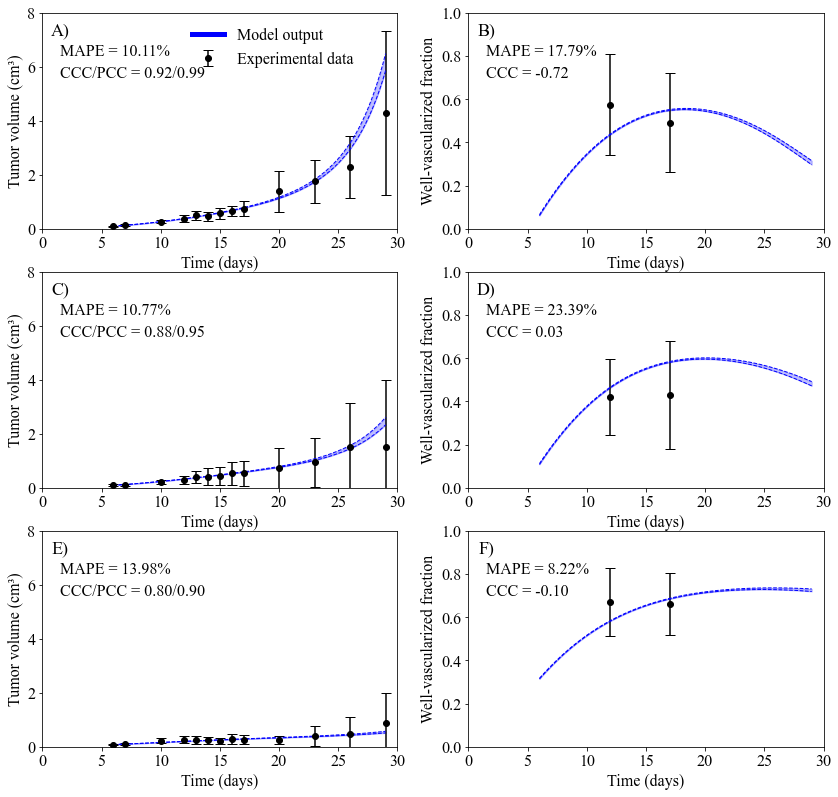

In [3]:
def fitting_solution(input_n,model_n,queso,data,allfilenames,show=False,save=False,extra=False,pos=0,using_chain=False):
    model_names=["T    ",
                 "TV1  ",
                 "TV2  ",
                 "TVni1",
                 "TVni2",
                 "TVi1 ",
                 "TVi2 ",
                 "TVe1 ",
                 "TVe2 ",
                 "TVie1",
                 "TVie2"]
    cal_par = np.loadtxt('./outputQueso/parameters_d123_m6.dat')
    queso_par = np.loadtxt('./outputQueso/lastchain_d123_m6.dat')
    cal_par45 = np.loadtxt('./outputQueso/parameters_d45_m10.dat')
    queso_par45 = np.loadtxt('./outputQueso/lastchain_d45_m10.dat')
    #inds = np.random.randint(len(queso), size=10)
    if pos < 8:
        inds = np.random.randint(len(queso), size=(1000,len(queso[0])))
    else:
        inds = np.random.randint(len(queso), size=(1000,len(queso)))
    inds_par = np.random.randint(len(queso_par), size=(1000,len(queso_par[0])))
    inds_par45 = np.random.randint(len(queso_par45), size=(1000,len(queso_par45[0])))
    last_p = 0
    if model_n >= 10:
        last_p = 8
    elif model_n >= 6:
        last_p = 6
    elif model_n >= 4:
        last_p = 4
    elif model_n >= 2:
        last_p = 3
    files = str(input_n)
    n_files = len(files)
    all_tv = []
    all_vf = []
    all_hf = []
    all_min_tv = []
    all_max_tv = []
    all_min_hf = []
    all_max_hf = []
    all_pars = []
    for f in range(n_files):
        dt_time = data[0][0]
        tv_time = np.arange(dt_time[0],dt_time[-1]+0.25,0.25)
        tv_mean = data[0][1][int(files[f])-1]
        tv_std = data[0][2][int(files[f])-1]
        hf_time = data[1][0]
        hf_mean = data[1][1][int(files[f])-1]
        hf_std = data[1][2][int(files[f])-1]
        if model_n > 1:
            sol_data = []
            sol_hypo = []
            sol_pars = []
            if model_n == 2:
                for ind in inds:
                    sample = queso[ind]
                    y_sp = odeint(model_2, t=tv_time, y0=[tv_mean[0],1-sample[last_p+f]], args=tuple([[sample[0],sample[1],sample[2]]]))
                    sol_data.append(y_sp)
                    sol_hypo.append(1-y_sp[:,1])
                    sol_pars.append(sample)
            elif model_n == 3:
                for ind in inds:
                    sample = queso[ind]
                    y_sp = odeint(model_3, t=tv_time, y0=[tv_mean[0],1-sample[last_p+f]], args=tuple([[sample[0],sample[1],sample[2]]]))
                    sol_data.append(y_sp)
                    sol_hypo.append(1-y_sp[:,1])
                    sol_pars.append(sample)
            elif model_n == 4:
                for ind in inds:
                    sample = queso[ind]
                    y_sp = odeint(model_4, t=tv_time, y0=[tv_mean[0],1-sample[last_p+f]], args=tuple([[sample[0],sample[1],sample[2],sample[3]]]))
                    sol_data.append(y_sp)
                    sol_hypo.append(1-y_sp[:,1])
                    sol_pars.append(sample)
            elif model_n == 5:
                for ind in inds:
                    sample = queso[ind]
                    y_sp = odeint(model_5, t=tv_time, y0=[tv_mean[0],1-sample[last_p+f]], args=tuple([[sample[0],sample[1],sample[2],sample[3]]]))
                    sol_data.append(y_sp)
                    sol_hypo.append(1-y_sp[:,1])
                    sol_pars.append(sample)
            elif model_n == 6:
                for ind in inds:
                    sample = np.zeros(len(queso[0]))
                    for si in range(len(sample)):
                        sample[si] = queso[ind[si]][si].copy()
                    #sample = queso[ind].copy()
                    if int(files[f]) == 1:
                        sample[4] = 0
                    y_sp = odeint(model_6, t=tv_time, y0=[tv_mean[0],1-sample[last_p+f]], args=tuple([[sample[0],sample[1],sample[2],sample[3],sample[4],sample[5]]]))
                    sol_data.append(y_sp)
                    sol_hypo.append(1-y_sp[:,1])
                    sol_pars.append(sample)
            elif model_n == 7:
                for ind in inds:
                    sample = queso[ind].copy()
                    if int(files[f]) == 1:
                        sample[4] = 0.0
                    y_sp = odeint(model_7, t=tv_time, y0=[tv_mean[0],1-sample[last_p+f]], args=tuple([[sample[0],sample[1],sample[2],sample[3],sample[4],sample[5]]]))
                    sol_data.append(y_sp)
                    sol_hypo.append(1-y_sp[:,1])
                    sol_pars.append(sample)
            elif model_n == 8:
                for ind in inds:
                    sample = queso[ind].copy()
                    if int(files[f]) == 1:
                        sample[4] = 0.0
                    y_sp = odeint(model_8, t=tv_time, y0=[tv_mean[0],1-sample[last_p+f]], args=tuple([[sample[0],sample[1],sample[2],sample[3],sample[4],sample[5]]]))
                    sol_data.append(y_sp)
                    sol_hypo.append(1-y_sp[:,1])
                    sol_pars.append(sample)
            elif model_n == 9:
                for ind in inds:
                    sample = queso[ind].copy()
                    if int(files[f]) == 1:
                        sample[4] = 0.0
                    y_sp = odeint(model_9, t=tv_time, y0=[tv_mean[0],1-sample[last_p+f]], args=tuple([[sample[0],sample[1],sample[2],sample[3],sample[4],sample[5]]]))
                    sol_data.append(y_sp)
                    sol_hypo.append(1-y_sp[:,1])
                    sol_pars.append(sample)
            elif model_n == 10:
                #for ind in inds:
                for ii in range(len(inds)):
                    ind = inds[ii]
                    if pos < 8:
                        sample = np.zeros(len(queso[0]))
                    else:
                        sample = np.zeros(1)
                    for si in range(len(sample)):
                        if pos < 8:
                            sample[si] = queso[ind[si]][si].copy()
                        else:
                            sample[si] = queso[ind[si]].copy()
                    #sample = queso[ind].copy()
                    if int(files[f]) == 1:
                        sample[4] = 0.0
                        sample[6] = 0.0
                    if int(files[f]) == 4:
                        sample[0] = 0.0
                    if input_n == 6:
                        full_pars = [queso_par[inds_par[ii][0]][0],queso_par[inds_par[ii][1]][1],queso_par[inds_par[ii][2]][2],queso_par[inds_par[ii][3]][3],queso_par[inds_par[ii][4]][4],queso_par[inds_par[ii][5]][5],queso_par45[inds_par45[ii][0]][0],queso_par45[inds_par45[ii][1]][1]]
                        if extra:
                            full_pars[pos] = sample[1]
                        y_sp = odeint(model_10, t=tv_time, y0=[tv_mean[0],1-sample[0]], args=tuple([[full_pars[0],full_pars[1],full_pars[2],full_pars[3],full_pars[4],full_pars[5],full_pars[6],full_pars[7]]]))
                        sol_pars.append(np.array(full_pars))
                    elif input_n == 6:
                        y_sp = odeint(model_10, t=tv_time, y0=[tv_mean[0],1-sample[8]], args=tuple([[sample[0],sample[1],sample[2],sample[3],sample[4],sample[5],sample[6],sample[7]]]))
                        sol_pars.append(np.array(sample))
                    else:
                        full_pars = [queso_par[inds_par[ii][0]][0],queso_par[inds_par[ii][1]][1],queso_par[inds_par[ii][2]][2],queso_par[inds_par[ii][3]][3],queso_par[inds_par[ii][4]][4],queso_par[inds_par[ii][5]][5],sample[0],sample[1]]
                        y_sp = odeint(model_10, t=tv_time, y0=[tv_mean[0],1-sample[2+f]], args=tuple([[queso_par[inds_par[ii][0]][0],queso_par[inds_par[ii][1]][1],queso_par[inds_par[ii][2]][2],queso_par[inds_par[ii][3]][3],queso_par[inds_par[ii][4]][4],queso_par[inds_par[ii][5]][5],sample[0],sample[1]]]))
                        sol_pars.append(np.array(full_pars))
                    sol_data.append(y_sp)
                    sol_hypo.append(1-y_sp[:,1])
            elif model_n == 11:
                for ind in inds:
                    sample = queso[ind].copy()
                    if int(files[f]) == 1:
                        sample[4] = 0.0
                        sample[6] = 0.0
                    y_sp = odeint(model_11, t=tv_time, y0=[tv_mean[0],1-sample[last_p+f]], args=tuple([[sample[0],sample[1],sample[2],sample[3],sample[4],sample[5],sample[6],sample[7]]]))
                    sol_data.append(y_sp)
                    sol_hypo.append(1-y_sp[:,1])
                    sol_pars.append(sample)
            arr = np.empty([len(sol_data),len(sol_data[0])])
            for i in range(len(sol_data)):
                arr[i,:]=sol_data[i][:,0]
            avg_pre = []
            min_pre = []
            max_pre = []
            for i in range(len(arr[0])):
                m = mean_confidence_interval(arr[:,i],0.95)
                avg_pre.append(m[0])
                min_pre.append(m[1])
                max_pre.append(m[2])
            tv_avg_pre_vf = avg_pre 
            arr = np.empty([len(sol_data),len(sol_data[0])])
            for i in range(len(sol_data)):
                arr[i,:]=sol_data[i][:,1]
            avg_pre_h = []
            min_pre_h = []
            max_pre_h = []
            for i in range(len(arr[0])):
                m = mean_confidence_interval(arr[:,i],0.95)
                avg_pre_h.append(m[0])
                min_pre_h.append(m[1])
                max_pre_h.append(m[2])
            vf_avg_pre_vf = avg_pre_h
            hf_avg_pre_vf = [1.0 - x for x in vf_avg_pre_vf]
        sol_pars = np.array(sol_pars)
        sol_pars = sol_pars.mean(axis=0)
        all_pars.append(sol_pars)        
        all_tv.append(tv_avg_pre_vf)
        all_vf.append(vf_avg_pre_vf)
        all_hf.append(hf_avg_pre_vf)
        all_min_tv.append(min_pre)
        all_max_tv.append(max_pre)
        all_min_hf.append(min_pre_h)
        all_max_hf.append(max_pre_h)    
    if show or save:
        fig, axes = plt.subplots(n_files,2, figsize=(14, 4.5*n_files), sharex=False)
        for f in range(n_files):
            dt_time = data[0][0]
            tv_time = np.arange(dt_time[0],dt_time[-1]+0.25,0.25)
            tv_mean = data[0][1][int(files[f])-1]
            tv_std = data[0][2][int(files[f])-1]
            hf_time = data[1][0]
            hf_mean = data[1][1][int(files[f])-1]
            hf_std = data[1][2][int(files[f])-1]
            min_pre = all_min_tv[f]
            max_pre = all_max_tv[f]
            tv_avg_pre_vf = all_tv[f]
            min_pre_h = all_min_hf[f]
            max_pre_h = all_max_hf[f]
            hf_avg_pre_vf = all_hf[f]
            if n_files == 1:
                ax = axes[0]
            else:
                ax = axes[f][0]
            #ax.text(0.5,0.9,allfilenames[int(files[f])-1][1],horizontalalignment='center',transform=ax.transAxes)
            ax.errorbar(dt_time,tv_mean,tv_std,linestyle='None',color='black',marker='o',capsize=5,label='Experimental data')
            #ax.fill_between(tv_time, min_pre, max_pre, color='blue')
            
            ax.fill_between(tv_time, min_pre, max_pre, alpha=0.25, color='blue')
            ax.plot(tv_time, min_pre, linewidth=1, linestyle="--",color='blue')
            ax.plot(tv_time, max_pre, linewidth=1, linestyle="--",color='blue')
            avg_tv_full = []
            Tmin_tv_full = []
            Tmax_tv_full = []
            for t in range(len(dt_time)):
                b = np.where(tv_time == dt_time[t])
                if len(b[0]) > 0:
                    avg_tv_full.append(tv_avg_pre_vf[b[0][0]])
                    Tmin_tv_full.append(min_pre[b[0][0]])
                    Tmax_tv_full.append(max_pre[b[0][0]])
            r_ccc = ccc(tv_mean, np.array(avg_tv_full))
            r_ccc_min = ccc(tv_mean, np.array(Tmin_tv_full))
            r_ccc_max = ccc(tv_mean, np.array(Tmax_tv_full))
            m_ccc = np.array([r_ccc_min,r_ccc_max])
            print(r_ccc,m_ccc.mean(),m_ccc.std())
            r_pcc = pcc(tv_mean, np.array(avg_tv_full))
            r_mape = mape(tv_mean, np.array(avg_tv_full))
            r_nrmse = nrmse(tv_mean, np.array(avg_tv_full))
            if f == 0:
                ax.plot(0,0,'-', linewidth=5,color='blue',label='Model output')
                #ax.legend(loc='lower right', bbox_to_anchor=(1.75, -0.4),ncol=4,fancybox=False, shadow=False, frameon=False,fontsize=18)
                ax.legend(loc='upper center',bbox_to_anchor=(0.65, 1),ncol=1,fancybox=False, shadow=False, frameon=False)
            ax.text(.05,.9,ascii_uppercase[2*f]+')',horizontalalignment='center',transform=ax.transAxes,fontsize=18)
            ax.text(.05,.7,'CCC/PCC = {:.2f}/{:.2f}'.format(r_ccc,r_pcc),horizontalalignment='left',transform=ax.transAxes)
            ax.text(.05,.8,'MAPE = {:.2f}%'.format(r_mape),horizontalalignment='left',transform=ax.transAxes)
            #ax.text(.05,.6,'NRMSE = {:.2f}%'.format(r_nrmse),horizontalalignment='left',transform=ax.transAxes)
            ax.set_xlabel('Time (days)')
            ax.set_ylabel('Tumor volume (cm³)');
            ax.set_xlim((0,30))
            if n_files == 1:
                maxp = [0.6]
                ax.set_ylim((0,maxp[f]))
                ax = axes[1]
            else:
                ax.set_ylim((0,8))
                ax = axes[f][1]
            #ax.errorbar(hf_time,hf_mean,hf_std,linestyle='None',color='black',marker='o',capsize=5)
            #ax.fill_between(tv_time, [1.0 - x for x in max_pre_h], [1.0 - x for x in min_pre_h], color='blue')
            #ax.plot(tv_time, hf_avg_pre_vf, color='blue', label='Calibration with means (95% CI)')
            #avg_hf_full = []
            #for t in range(len(hf_time)):
            #    b = np.where(tv_time == hf_time[t])
            #    if len(b[0]) > 0:
            #        avg_hf_full.append(hf_avg_pre_vf[b[0][0]])
            #r_ccc = ccc(hf_mean, np.array(avg_hf_full))
            #r_pcc = pcc(hf_mean, np.array(avg_hf_full))
            #r_mape = mape(hf_mean, np.array(avg_hf_full))
            #ax.text(.5,.9,'CCC/PCC = {:.2f}/{:.2f}'.format(r_ccc,r_pcc),horizontalalignment='left',transform=ax.transAxes)
            #ax.text(.5,.8,'MAPE = {:.2f}%'.format(r_mape),horizontalalignment='left',transform=ax.transAxes)
            #ax.set_xlabel('Time (days)')
            #ax.set_ylabel('Hypoxic fraction')
            #ax.set_xlim((0,30))
            #ax.set_ylim((0,1))
            #if n_files == 1:
            #    ax = axes[2]
            #else:
            #    ax = axes[f][2]
            ax.errorbar(hf_time,1-hf_mean,hf_std,linestyle='None',color='black',marker='o',capsize=5)
            #ax.fill_between(tv_time, min_pre_h, max_pre_h, color='blue')
            
            ax.fill_between(tv_time, min_pre_h, max_pre_h, alpha=0.25, color='blue')
            ax.plot(tv_time, min_pre_h, linewidth=1, linestyle="--",color='blue')
            ax.plot(tv_time, max_pre_h, linewidth=1, linestyle="--",color='blue')
            
            #ax.plot(tv_time, [1.0 - x for x in hf_avg_pre_vf], color='blue', label='Calibration with means (95% CI)')
            
            avg_hf_full = []
            for t in range(len(hf_time)):
                b = np.where(tv_time == hf_time[t])
                if len(b[0]) > 0:
                    avg_hf_full.append(1.0-hf_avg_pre_vf[b[0][0]])
            r_ccc = ccc(1.0-hf_mean, np.array(avg_hf_full))
            r_mape = mape(1.0-hf_mean, np.array(avg_hf_full))
            r_nrmse = nrmse(1.0-hf_mean, np.array(avg_hf_full))
            ax.text(.05,.9,ascii_uppercase[2*f+1]+')',horizontalalignment='center',transform=ax.transAxes,fontsize=18)
            ax.text(.05,.7,'CCC = {:.2f}'.format(r_ccc),horizontalalignment='left',transform=ax.transAxes)
            ax.text(.05,.8,'MAPE = {:.2f}%'.format(r_mape),horizontalalignment='left',transform=ax.transAxes)
            #ax.text(.5,.7,'NRMSE = {:.2f}%'.format(r_nrmse),horizontalalignment='left',transform=ax.transAxes)
            ax.set_xlabel('Time (days)')
            ax.set_ylabel('Well-vascularized fraction')
            ax.set_xlim((0,30))
            ax.set_ylim((0,1))
        if save:
            if extra:
                plt.savefig('fig_mean_d' + str(input_n) + '_m' + str(model_n) + '_pos' + str(pos) + '.pdf', bbox_inches = 'tight', pad_inches = 0.02)
            else:
                plt.savefig('fig_mean_d' + str(input_n) + '_m' + str(model_n) + '.pdf', bbox_inches = 'tight', pad_inches = 0.02)
        if show == True:
            plt.show()
        else:
            plt.close(fig) 
    return [[all_tv,all_min_tv,all_max_tv],[all_hf,all_min_hf,all_max_hf],all_pars]





np.random.seed(2021) # For reproducibility
input_n = 123
model_n = 6
output_base = get_chain(input_n,model_n,show=False,save=False)
mean_solA = fitting_solution(input_n,model_n,output_base[0],meanData,data[2],show=True,save=True)

0.7872454332356724 0.7867138699319456 0.025374438330147575
0.9151592786205479 0.9127230699384742 0.015385104550552198


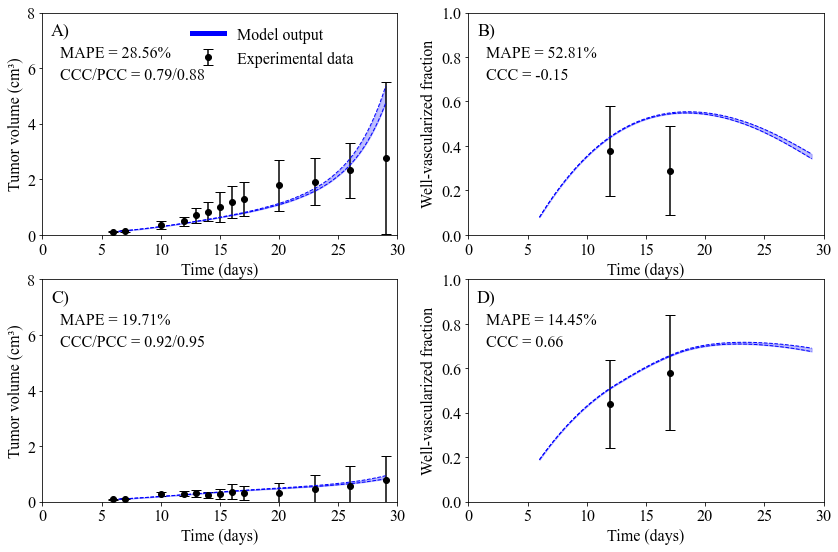

In [4]:
np.random.seed(27) # For reproducibility
input_n = 45
model_n = 10
output_base = get_chain(input_n,model_n,show=False,save=False)
mean_solB = fitting_solution(input_n,model_n,output_base[0],meanData,data[2],show=True,save=True)

# Step 3
Calibrate scenario F

0.775375149612517 0.7753189580958131 0.008408585168789895


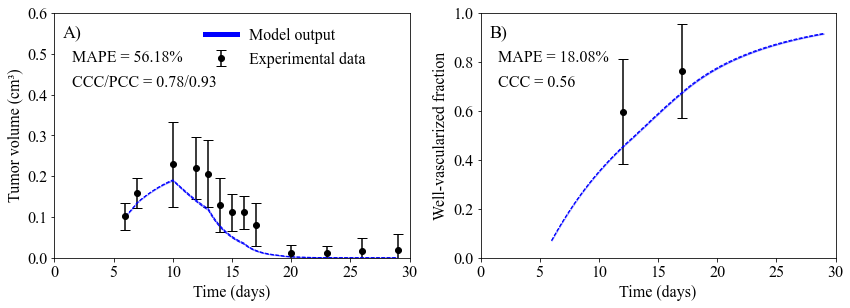

In [8]:
position = 4
input_n = 6
model_n = 10
repl = True
output = get_chain(input_n,model_n,show=False,save=False)
mean_solC = fitting_solution(input_n,model_n,output[0],meanData,data[2],show=True,save=True,extra=repl,pos=position)

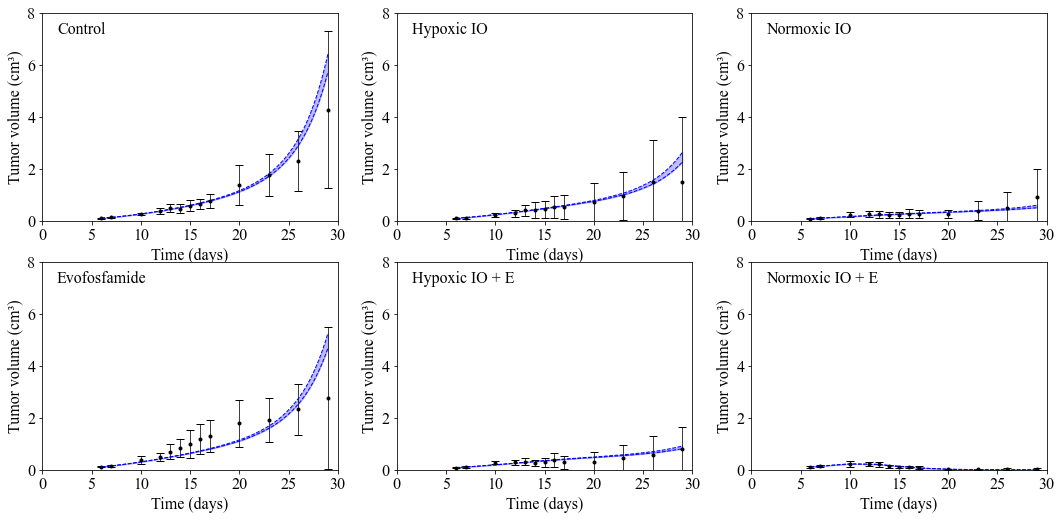

In [9]:
nRows = 2
nCols = 3
model_avg = [mean_solA[0][0][0],mean_solA[0][0][1],mean_solA[0][0][2],mean_solB[0][0][0],mean_solB[0][0][1],mean_solC[0][0][0]]
model_min = [mean_solA[0][1][0],mean_solA[0][1][1],mean_solA[0][1][2],mean_solB[0][1][0],mean_solB[0][1][1],mean_solC[0][1][0]]
model_max = [mean_solA[0][2][0],mean_solA[0][2][1],mean_solA[0][2][2],mean_solB[0][2][0],mean_solB[0][2][1],mean_solC[0][2][0]]
tv_time = np.arange(meanData[0][0][0],meanData[0][0][-1]+0.25,0.25)
fig, axes = plt.subplots(nrows = nRows,ncols = nCols, figsize=(nCols*6, 4.2*nRows), sharex=False)
axes.shape = (nRows*nCols)
y_max = []
for i in range(len(meanData[0][1])):
    ax = axes[i]
    ax.errorbar(meanData[0][0],meanData[0][1][i],meanData[0][2][i],linestyle='None',color='black',marker='o',markersize=3,capsize=4,linewidth=0.75)
    ax.fill_between(tv_time, model_min[i], model_max[i], alpha=0.25, color='blue')
    ax.plot(tv_time, model_min[i], linewidth=1, linestyle="--",color='blue')
    ax.plot(tv_time, model_max[i], linewidth=1, linestyle="--",color='blue')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Tumor volume (cm³)');
    ax.set_xlim((0,30))
    y_max.append(ax.get_ylim()[1])
for i in range(len(meanData[0][1])):
    ax = axes[i]
    ax.set_ylim((0,round(max(y_max))))
    ax.text(.05,.9,data[2][i][1],horizontalalignment='left',transform=ax.transAxes)
plt.savefig('new_data_model.pdf', bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

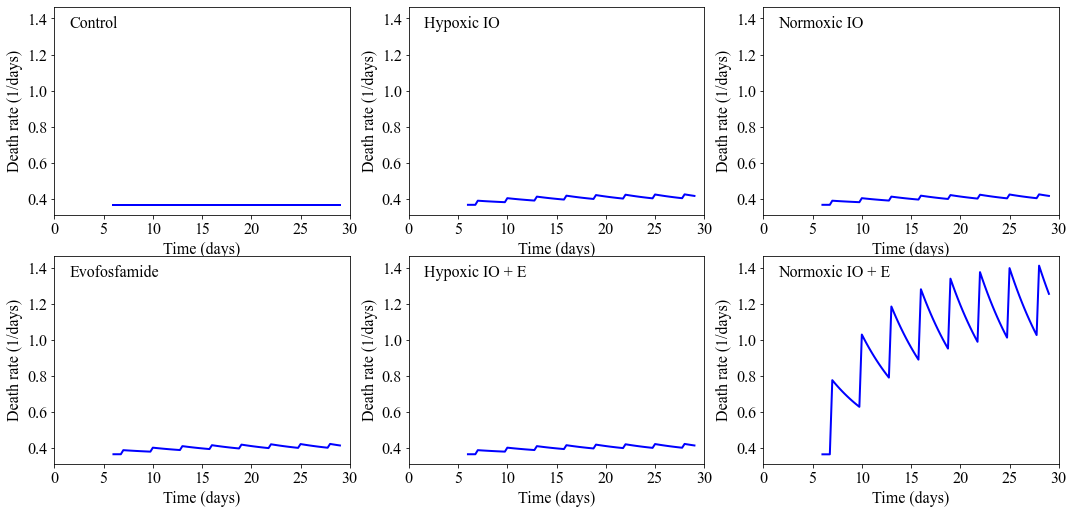

In [10]:
def drug_dynamics(t, theta):
    D = 1.0
    if t>=7:
        n_treat = int((t-7)/3)
        for n in range(0,n_treat+1):
            D += theta[4]*np.exp(-theta[5]*(t-(7+n*3)))
    return D * theta[3]
model_pars = [mean_solA[2][0],mean_solA[2][1],mean_solA[2][2],mean_solB[2][0],mean_solB[2][1],mean_solC[2][0]]
nRows = 2
nCols = 3
tv_time = np.arange(meanData[0][0][0],meanData[0][0][-1]+0.25,0.25)
fig, axes = plt.subplots(nrows = nRows,ncols = nCols, figsize=(nCols*6, 4.2*nRows), sharex=False)
axes.shape = (nRows*nCols)
y_max = []
y_min = []
for i in range(len(meanData[0][1])):
    ax = axes[i]
    drug = [drug_dynamics(t,model_pars[i]) for t in tv_time]
    ax.plot(tv_time, drug, linewidth=2, linestyle="-",color='blue')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Death rate (1/days)');
    ax.set_xlim((0,30))
    y_max.append(ax.get_ylim()[1])
    y_min.append(ax.get_ylim()[0])
plt.savefig('death_rate_original.pdf', bbox_inches = 'tight', pad_inches = 0.02)
for i in range(len(meanData[0][1])):
    ax = axes[i]
    ax.set_ylim((min(y_min),max(y_max)))
    ax.text(.05,.9,data[2][i][1],horizontalalignment='left',transform=ax.transAxes)
plt.savefig('death_rate_scaled.pdf', bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

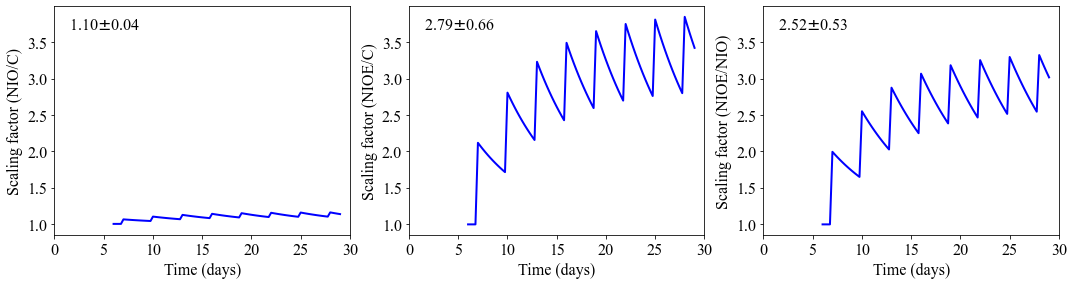

In [11]:
drugC = np.array([drug_dynamics(t,model_pars[0]) for t in tv_time])
drugNIO = np.array([drug_dynamics(t,model_pars[2]) for t in tv_time])
drugNIOE = np.array([drug_dynamics(t,model_pars[5]) for t in tv_time])
nRows = 1
nCols = 3
fig, axes = plt.subplots(nrows = nRows,ncols = nCols, figsize=(nCols*6, 4.2*nRows), sharex=False)
axes.shape = (nRows*nCols)
scaling_factors = [np.array(drugNIO/drugC),np.array(drugNIOE/drugC),np.array(drugNIOE/drugNIO)]
ylbl_scale = ['(NIO/C)','(NIOE/C)', '(NIOE/NIO)']
y_max = []
y_min = []
for i in range(len(scaling_factors)):
    ax = axes[i]
    ax.plot(tv_time, scaling_factors[i], linewidth=2, linestyle="-",color='blue')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Scaling factor ' + ylbl_scale[i]);
    ax.set_xlim((0,30))
    y_max.append(ax.get_ylim()[1])
    y_min.append(ax.get_ylim()[0])
plt.savefig('scaling_death_rate_original.pdf', bbox_inches = 'tight', pad_inches = 0.02)
for i in range(len(scaling_factors)):
    ax = axes[i]
    ax.set_ylim((min(y_min),max(y_max)))
    ax.text(.05,.9,'{:.2f}$\pm${:.2f}'.format(scaling_factors[i].mean(),scaling_factors[i].std()),horizontalalignment='left',transform=ax.transAxes)
plt.savefig('scaling_death_rate_scaled.pdf', bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

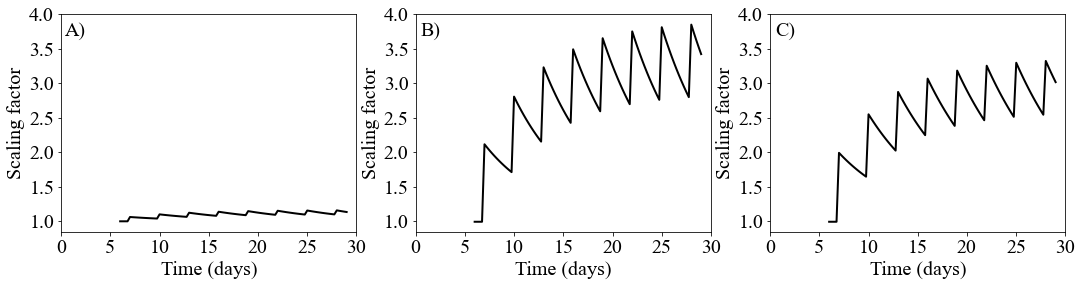

In [12]:
plt.rcParams['font.size'] = '20'
plt.rcParams["font.family"] = "Times New Roman"
drugC = np.array([drug_dynamics(t,model_pars[0]) for t in tv_time])
drugNIO = np.array([drug_dynamics(t,model_pars[2]) for t in tv_time])
drugNIOE = np.array([drug_dynamics(t,model_pars[5]) for t in tv_time])
nRows = 1
nCols = 3
lbl = ['A)','B)','C)','D)']
fig, axes = plt.subplots(nrows = nRows,ncols = nCols, figsize=(nCols*6, 4*nRows), sharex=False)
axes.shape = (nRows*nCols)
scaling_factors = [np.array(drugNIO/drugC),np.array(drugNIOE/drugC),np.array(drugNIOE/drugNIO)]
ylbl_scale = ['(NIO/C)','(NIOE/C)', '(NIOE/NIO)']
y_max = []
y_min = []
for i in range(len(scaling_factors)):
    ax = axes[i]
    ax.plot(tv_time, scaling_factors[i], linewidth=2, linestyle="-",color='black')
    ax.set_xlabel('Time (days)')
    #ax.set_ylabel('Scaling factor ' + ylbl_scale[i])
    ax.set_ylabel('Scaling factor')
    ax.set_xlim((0,30))
    y_max.append(ax.get_ylim()[1])
    y_min.append(ax.get_ylim()[0])
plt.savefig('scaling_death_rate_original.pdf', bbox_inches = 'tight', pad_inches = 0.02)
for i in range(len(scaling_factors)):
    ax = axes[i]
    ax.set_ylim((min(y_min),max(y_max)))
    ax.set_xticks(np.arange(0, 31, 5))
    ax.set_yticks(np.arange(1, 4.1, .5))
    ax.text(0.05,0.9,lbl[i],horizontalalignment='center',transform=ax.transAxes,fontsize=20)
    #ax.text(.05,.9,'{:.2f}$\pm${:.2f}'.format(scaling_factors[i].mean(),scaling_factors[i].std()),horizontalalignment='left',transform=ax.transAxes)
plt.savefig('scaling_death_rate_nolbl.pdf', bbox_inches = 'tight', pad_inches = 0.02)
plt.show()